# Projet de Probabilités et Statistiques:
##### CHAKHCHOUKH Mehdi, SABOURIN Yves, GUYOT Julien.
## Exercice 2: Bayésien Naif de Bernoulli.

L'objet de cet exercice est d'implémenter et d'expérimenter un classifieur Bayésien Naif, version Bernoulli, pour les images binarisées.

Il est interessant de noter que cet exercice se base sur le TP4 vu en cours. Nous pouvons donc nous baser sur ce Tp pour l'execution de cet exercice.

Cet exercice est réalisé sur les données MNIST.
Ce corpus rassemble des images (observations) de chiffres isolés et manuscrits ainsi que les classes associées (les labels ou les réponses attendues). Il s'agit donc d'un problème de classification à 10 classes (de 0 à 9). L'objectif est d'assigner le bon chiffre à une image. 

 On suppose avoir à disposition: 
* des données d'apprentissage (50000 images)
* des données de test (10000 images)



<class 'numpy.ndarray'>
(784,)


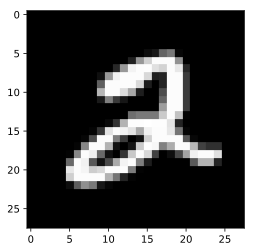

In [1]:
# Version python3 pour le chargement des données
import pickle, gzip, numpy, math

# Charger le dataset
f = gzip.open('mnist.pkl.gz', 'rb')
u = pickle._Unpickler(f)
u.encoding = 'latin1'
p = u.load()
train_set, valid_set, test_set = p

######################################
# Un peu d'exploration du dataset
im = train_set[0][0] # la première image
label = train_set[1][0] # son label
print(type(im))
print(im.shape)


%matplotlib inline
%config InlineBackend.figure_formats=['svg']
%config InlineBackend.figure_format = 'svg'
import matplotlib
# Visualisation d'une image: 
im = train_set[0][5]
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(im.reshape(28,28) , matplotlib.pyplot.cm.gray)

######################################
# Récupération des images et des labels
images = train_set[0]
labels = train_set[1]
tests  = test_set[0]
lbls   = test_set[1]
######################################


#  On commence par implementer le Bayesien naïf Gaussien pour pouvoir faire la comparaion avec le Bayésien Naif de Bernoulli qu'on fera par la suite.

## Bayesien Naif Gaussien (continu)


Les observations sont de nature continue. Chaque image contient 784 pixels dont la valeur est réelle et normalisée entre 0 et 1. On binarisera ces données pour la partie Bayésien Naif de Bernoulli, mais ici nous allons les modéliser ainsi en utilisant des gaussiennes.

Une image est un vecteur de caractéristiques contenant 784 composantes. Partons de cette simple représentation. L'hypothèse naïve implique que chaque composante est indépendante des autres. Dans le cas présent, chaque pixel est donc modélisé par une gaussienne. La matrice de covariance est donc diagonale. 


In [2]:
# copie des images et des labels
images_Gaussien =  images
labels_Gaussien =  labels
tests_Gaussien  =  tests
lbls_Gaussien   =  lbls

In [3]:
taille = 784 # le nombre de pixels de l'image


moyenne_Gaussien  = []
variance_Gaussien = []

moyenne_Gaussien  = [numpy.mean(images_Gaussien[labels_Gaussien==i], axis=0) for i in range(10)]
variance_Gaussien = [numpy.var(images_Gaussien[labels_Gaussien ==i], axis=0) for i in range(10)]

##Fonction d'inference: on lui donne un indice n 
#et elle revoit une inferance pour l'image[n] du test set
def inference_Gaussien(n):
    maximum = -100000 # on initialise le max a -inf 
    res     = 0 # le resultat de l inference, un entier entre 1 et 9 (la classe predite)
    
    #Nous alons verifier la vraissemblance de l'appartenance des pixels de l'image testee 
    #pour chaque classe
    
    for classe in range(10):
        py    = len(images_Gaussien[labels_Gaussien==classe]) / len(images_Gaussien)
        somme = 0 # vraisemblance d'appartenir a la classe "classe"
        vect  = variance_Gaussien[classe]
        moy   = moyenne_Gaussien[classe]
        for i in range(784):
            if vect[i] > 0: 
                data  = tests_Gaussien[n][i]
                somme += math.log(2*math.pi*(vect[i]))+(((data-moy[i])**2)/vect[i])
        somme = math.log(py) - (0.5 * somme)
        if maximum < somme:
            res = classe # on garde en mem le meilleur resultat (la classe la plus vraisemblante)
            maximum = somme 
    return res # une fois qu on a testé avec les 9 classes on renvois la classe la plus vraisemblante


#Fonction de test; on lui donne un indice n et elle test si la classe predite par 
# "inference_Gaussien" est bien la bonne classe (le label de l'image )
def test_Gaussien(n):
    if inference_Gaussien(n)==lbls_Gaussien[n]:
        #Affichage en temps réel pour voir l'inferance en directe
        #Ne décommentez que pour tester / voir a quoi cela resemble 
        #  car l'affichage nuit grandement aux performances et a la vitesse de calcul
        #print("infered ", inference_Gaussien(n) ,"for :", lbls_Gaussien[n])
        return 1
    return 0

#Fonction de taux d'erreur: on lui donne un indice n 
#et elle calcule le taux d'erreur moyen de l'inference sur les n premiers elements du 
# dataset de test
def taux_erreur_Gaussien(n):
    tmp   = 0
    total = 0
    for i in range(n):
        total += 1
        tmp   += test_Gaussien(i)
    return 1-tmp/total

#Fonction showMissed: affiche une image des n premiers ratés que la fonction d'inference fait
def showMissed_Gaussien(n):
    i = 0 # compteur d'erreurs
    j = 0 # iterateur
    while(i<n): #condition d'arret: trouver n erreurs d'inference
        if(test_Gaussien(j)==0):
            i +=1 # on a trouvé une erreur donc on ajoute 1 a i
            im = tests_Gaussien[j]
            matplotlib.pyplot.show()
            matplotlib.pyplot.imshow(im.reshape(28,28) , matplotlib.pyplot.cm.gray)
            print("A predit",inference_Gaussien(j),"pour:")
        j+=1

In [4]:
#Fonction ultimate_taux_erreur_Gaussien: calcule le taux d'erreur pour 
#[1,100,500,1000,2000,5000,10000] tests et renvoie le tout dans un tableau
def ultimate_taux_erreur_Gaussien():
    res=[[1,0],[100,0],[500,0],[1000,0],[2000,0],[5000,0],[10000,0]]
    for i in range(len(res)):
        print("Etape",i,"/6")
        res[i][1] = taux_erreur_Gaussien(res[i][0])
    print("DONE")
    return res

BN_Gaussien_resultats  = ultimate_taux_erreur_Gaussien()


Etape 0 /6
Etape 1 /6
Etape 2 /6
Etape 3 /6
Etape 4 /6
Etape 5 /6
Etape 6 /6
DONE


In [5]:
#On affiche les résultats
print(BN_Gaussien_resultats)

[[1, 0.0], [100, 0.18999999999999995], [500, 0.25], [1000, 0.253], [2000, 0.274], [5000, 0.2754], [10000, 0.2237]]


# Bayésien naïf de Bernoulli (discret) 

Reprendre la même tâche mais en binarisant les images. Pour cela, le modèle de chaque pixel est une binomiale. 

## TODO
- Quels sont les paramètres à estimer pour chaque classe ? 
- Comment les stockés ? 
- Implémenter l'estimation, puis l'inférence. (On peut dans un premier temps réutiliser l'implémentation existante de Sklearn)


In [6]:
## On copie le dataset
from copy import deepcopy
bin_train_set =  deepcopy(train_set)
bin_valid_set =  deepcopy(valid_set)
bin_test_set  =  deepcopy(test_set)

######################################
#Binarisation:                       #
#Chaque pixel est arrondie a 0 ou a 1 selon sa valeur d'origine
for i in range(len(train_set[0])):
    bin_train_set[0][i] = (train_set[0][i] >= 0.5).astype(numpy.int_)

for i in range(len(test_set[0])):
    bin_test_set[0][i]  = (test_set[0][i]  >= 0.5).astype(numpy.int_)

for i in range(len(valid_set[0])):
    bin_valid_set[0][i] = (valid_set[0][i] >= 0.5).astype(numpy.int_)
######################################


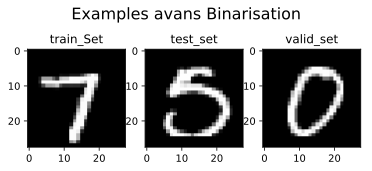

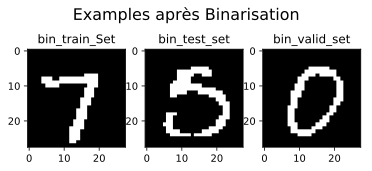

In [7]:
# Visualisation:
%matplotlib inline
%config InlineBackend.figure_formats =['svg']
%config InlineBackend.figure_format  = 'svg'

import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

#### Images d'examples avans Binarisation
fig = plt.figure(1)
fig.suptitle('Examples avans Binarisation ', fontsize=16)

plt.subplot(131)
im = train_set[0][654]
plt.title('train_Set')
plt.imshow(im.reshape(28,28) , plt.cm.gray)

plt.subplot(132)
im = test_set[0][654]
plt.title('test_set')
plt.imshow(im.reshape(28,28) , plt.cm.gray)

plt.subplot(133)
im = valid_set[0][654]
plt.title('valid_set')
plt.imshow(im.reshape(28,28) , plt.cm.gray)

plt.gca().yaxis.set_minor_formatter(NullFormatter())
plt.subplots_adjust(top=1.2)

#### Images d'examples après Binarisation
fig = plt.figure(2)
fig.suptitle('Examples après Binarisation ', fontsize=16)

plt.subplot(131)
im = bin_train_set[0][654]
plt.title('bin_train_Set')
plt.imshow(im.reshape(28,28) , plt.cm.gray)

plt.subplot(132)
im = bin_test_set[0][654]
plt.title('bin_test_set')
plt.imshow(im.reshape(28,28) , plt.cm.gray)

plt.subplot(133)
im = bin_valid_set[0][654]
plt.title('bin_valid_set')
plt.imshow(im.reshape(28,28) , plt.cm.gray)

#Pour ajuster la position des images manuellement
plt.gca().yaxis.set_minor_formatter(NullFormatter())
plt.subplots_adjust(top=1.2)
#plt.subplots_adjust(top=1.3, bottom=0.08, left=0.40, right=0.95, hspace=0.25,wspace=0.35) 
######################################


In [8]:
# Récupération des images et des labels apres la binarisation
images_Bernoulli =  bin_train_set[0]
labels_Bernoulli =  bin_train_set[1]
tests_Bernoulli  =  bin_test_set[0]
lbls_Bernoulli   =  bin_test_set[1]

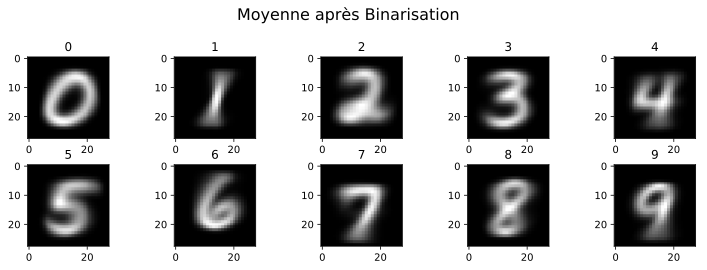

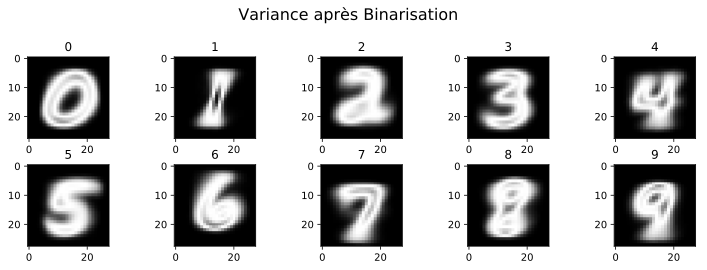

In [9]:

### Moy et Var OPTIONEL, mais bon pour l'exploration
moyenne_Bernoulli  = [] # moyenne des images de la meme classe 
variance_Bernoulli = [] # variance des images de la meme classe 

#On calcule la moyenne des images de la meme classe
moyenne_Bernoulli  = [numpy.mean(images_Bernoulli[labels_Bernoulli==i], axis=0) for i in range(10)] 
#On calcule variance des images de la meme classe
variance_Bernoulli = [numpy.var(images_Bernoulli [labels_Bernoulli==i], axis=0) for i in range(10)] 
#############################################

#On calcule la difference de moyenne et de variance entre le NB de Bernoulli et Gaussien
diff_moyenne = numpy.absolute(numpy.array(moyenne_Bernoulli) - numpy.array(moyenne_Gaussien))
diff_variance = numpy.absolute(numpy.array(variance_Bernoulli)- numpy.array(variance_Gaussien))
#############################################

############# AFFICHAGE MOYENNE #############
fig = plt.figure(3)
fig.suptitle('Moyenne après Binarisation ', fontsize=16)
fig.set_size_inches(12, 12)

##Boucle pour cree les plots de moyenne
for i in range(10):
    plt.subplot(2,5,i+1)
    im = moyenne_Bernoulli[i]
    plt.title(i)
    plt.imshow(im.reshape(28,28) , plt.cm.gray)
plt.subplots_adjust(top=1.5 ,hspace=-0.9, wspace=0.8)
#############################################

############# AFFICHAGE VARIANCE #############
fig = plt.figure(4)
fig.suptitle('Variance après Binarisation ', fontsize=16)
fig.set_size_inches(12, 12)
##Boucle pour cree les plots de moyenne
for i in range(10):
    plt.subplot(2,5,i+1)
    im = variance_Bernoulli[i]
    plt.title(i)
    plt.imshow(im.reshape(28,28) , plt.cm.gray)
plt.subplots_adjust(top=1.5 ,hspace=-0.9, wspace=0.8)
#############################################

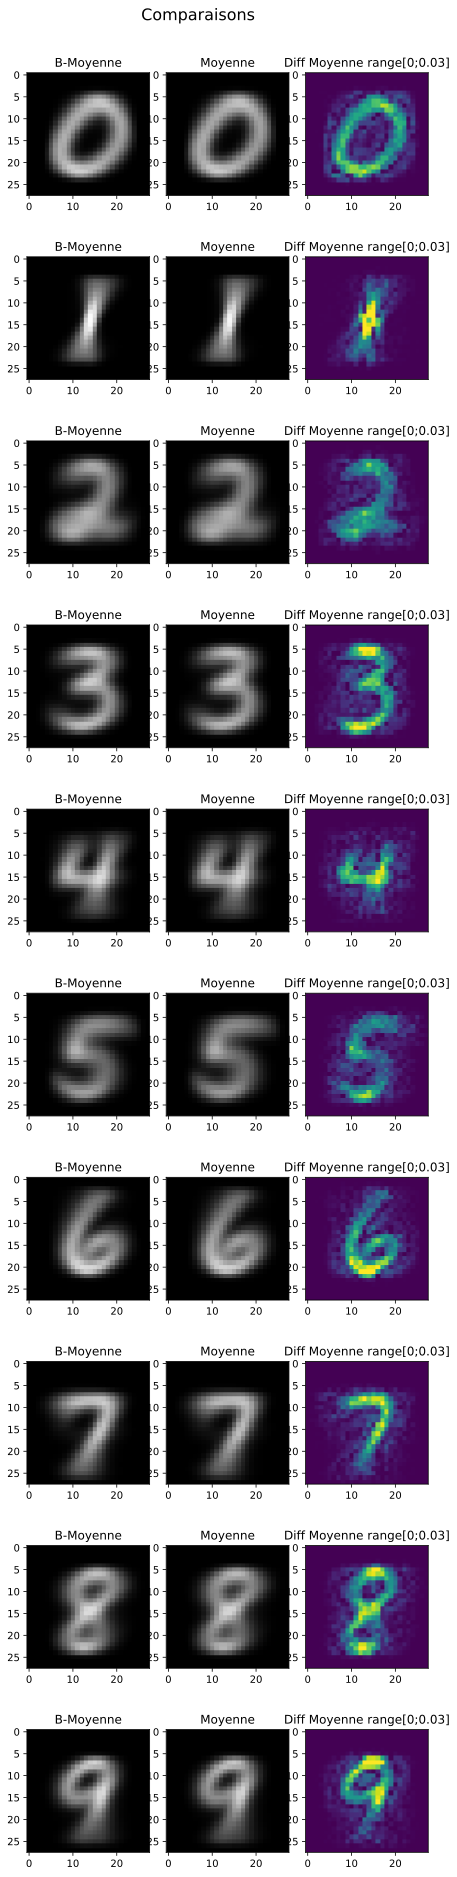

In [10]:
############# Comparaison de la moyenne entre le data binarisé et non binarisé #############
fig = plt.figure(5)
fig.suptitle('Comparaisons ', fontsize=16)
fig.set_size_inches(30, 30)

##Boucle pour cree les plots de moyenne
j=0
for i in range(1,29,3):
    plt.subplot(10,3,i)
    im = moyenne_Bernoulli[j]
    plt.title('B-Moyenne')
    plt.imshow(im.reshape(28,28) , plt.cm.gray,vmin=0, vmax=1)
    
    plt.subplot(10,3,i+1)
    im = moyenne_Gaussien[j]
    plt.title('Moyenne')
    plt.imshow(im.reshape(28,28) , plt.cm.gray,vmin=0, vmax=1)
    
    plt.subplot(10,3,i+2)
    im = diff_moyenne[j]
    plt.title('Diff Moyenne range[0;0.03]')
    plt.imshow(im.reshape(28,28),vmin=0, vmax=0.03)
    j+=1
plt.subplots_adjust(top=0.95 ,hspace=0.5, wspace=-0.9)
#############################################


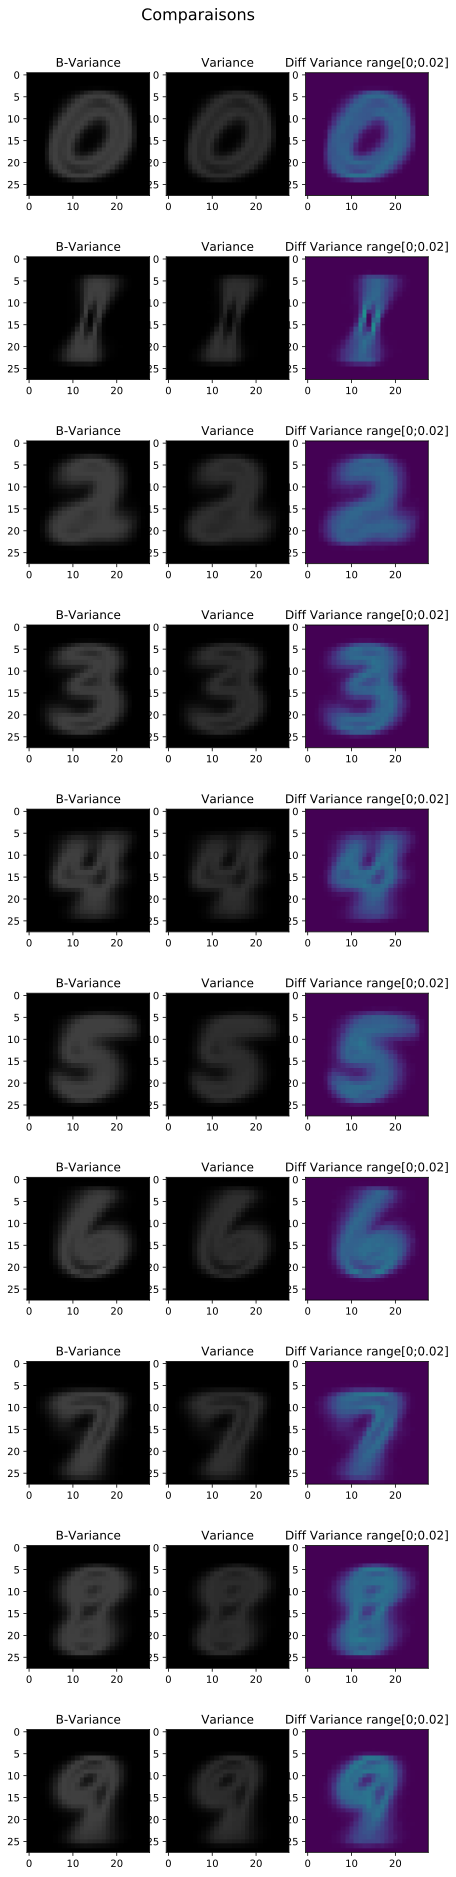

In [11]:
############# Comparaison de la Variance entre le data binarisé et non binarisé #############
fig = plt.figure(5)
fig.suptitle('Comparaisons ', fontsize=16)
fig.set_size_inches(30, 30)
##Boucle pour cree les plots de moyenne
j=0
for i in range(1,29,3):
    plt.subplot(10,3,i)
    im = variance_Bernoulli[(j)]
    plt.title('B-Variance')
    plt.imshow(im.reshape(28,28) , plt.cm.gray,vmin=0, vmax=1)
    
    plt.subplot(10,3,i+1)
    im = variance_Gaussien[(j)]
    plt.title('Variance')
    plt.imshow(im.reshape(28,28) , plt.cm.gray,vmin=0, vmax=1)
    
    plt.subplot(10,3,i+2)
    im = diff_variance[(j)]
    plt.title('Diff Variance range[0;0.02]')
    plt.imshow(im.reshape(28,28) , vmin=0, vmax=0.2)
    j+=1
plt.subplots_adjust(top=0.95 ,hspace=0.5, wspace=-0.9)
#############################################


In [12]:
##On compte le nombre d'images par classes (pour l'utiliser dans les lissage de Laplasse)
numberOfImagesInClass= numpy.array([0,0,0,0,0,0,0,0,0,0])
for i in range(len(labels_Bernoulli)):
    numberOfImagesInClass[labels_Bernoulli[i]]+=1
print(numberOfImagesInClass)

[4932 5678 4968 5101 4859 4506 4951 5175 4842 4988]


In [13]:
############# Lissage de Laplace #############
def laplaceSmoothing(tab , alpha):
    tab    =  numpy.array(tab)
    somme  = [numpy.sum(tab[labels_Bernoulli[0:len(tab)]==i],axis=0) for i in range(10)] #somme tous les pixels sur l axe 0 
                                                            #on fini avec une seule image de taille 784 par classe
    sommeP = [somme[i]+alpha for i in range(10)] #on ajoute alpha a tous les pixels 
    #print(sommeP[1])
    numerator = numpy.array([0,0,0,0,0,0,0,0,0,0])
    for i in range(10):
        numerator[i] = numberOfImagesInClass[i]+ 2* alpha
    res =[]
    for i in range(10):    
        res.append(sommeP[i] / numerator[i])
            
    return  numpy.array(res)
#############################################

In [14]:
#On fait un lissage sur les données de trainig avec un alpha de 0.001
laplaceS_train = laplaceSmoothing(images_Bernoulli, 0.001)
#On affiche la forme du resultat pour etre bien sur qu'il n y a pas eu de problem lors du lissage
print("Training dataset shape: ", images_Bernoulli.shape)
print("Shape of the laplace smoothed set: ",laplaceS_train.shape)

Training dataset shape:  (50000, 784)
Shape of the laplace smoothed set:  (10, 784)


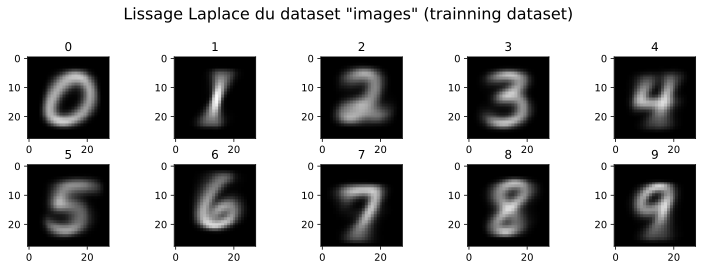

In [15]:
#On affiche des images du lissage pour l'observer
############# AFFICHAGE LISSAGE #############
fig = plt.figure(4)
fig.suptitle('Lissage Laplace du dataset "images" (trainning dataset) ', fontsize=16)
fig.set_size_inches(12, 12)
##Boucle pour cree les plots de lissage
for i in range(0,10):
    plt.subplot(2,5,i+1)
    im = laplaceS_train[i]
    plt.title(i)
    plt.imshow(im.reshape(28,28) , plt.cm.gray, vmin=0, vmax=1)
plt.subplots_adjust(top=1.5 ,hspace=-0.9, wspace=0.8)
#############################################


In [16]:
##Fonction d'inference: on lui donne un indice n 
#et elle revoit une inferance pour l'image[n] du test set
def inference_Bernoulli(n):
    maximum = -10000
    res     = 0
    for classe in range(10):
        somme = 1/10
        for i in range(784):
                py   = laplaceS_train[classe][i]
                data = tests_Bernoulli[n][i]
                somme += data*math.log(py)+(1-data)*math.log(1-py)
        if maximum < somme:
            res = classe
            maximum = somme
    return res

#Fonction de test; on lui donne un indice n et elle test si la classe predite par 
# "inference_Bernoulli" est bien la bonne classe (le label de l'image )
def test_Bernoulli(n):
    if inference_Bernoulli(n)==lbls_Bernoulli[n]:
        return 1
    return 0

#Fonction de test (voir plus haut) avec un affichage en temps réel
#A utiliser que pour tester / voir a quoi cela resemble, pas pour une utilisation normale 
#car l'affichage nuit grandement aux performances et a la vitesse de calcul
def afficheTest_Bernoulli(n, affichage):
    if inference_Bernoulli(n)==lbls_Bernoulli[n]:
        if affichage:
            print ("infered: ", inference_Bernoulli(n), "for :", lbls_Bernoulli[n])
        return 1
    return 0

#Fonction de taux d'erreur: on lui donne un indice n 
#et elle calcule le taux d'erreur moyen de l'inference sur les n premiers elements du 
# dataset de test
def taux_erreur_Bernoulli(n):
    tmp  = 0
    total= 0
    for i in range(n):
        total +=1       
        tmp   += test_Bernoulli(i) #on utilise le testing set
    return 1-tmp/total

#Fonction de taux de reussite: on lui donne un indice n 
#et elle calcule le taux de reussite moyen de l'inference sur les n premiers elements du 
# dataset de test
def taux_reussite_Bernoulli(n):
    tmp  = 0
    total= 0
    for i in range(n):
        total +=1       
        tmp   += test_Bernoulli(i)
    return tmp/total

#Fonction showMissed: affiche une image des n premiers ratés que la fonction d'inference fait
def showMissed_Bernoulli(n):
    i = 0 # compteur d'erreurs
    j = 0 # iterateur
    while(i<n): #condition d'arret: trouver n erreurs d'inference
        if(test_Bernoulli(j)==0):
            i+=1 ## on a trouvé une erreur on ajoute donc 1 a i
            im = tests_Bernoulli[j]
            matplotlib.pyplot.show()
            matplotlib.pyplot.imshow(im.reshape(28,28) , matplotlib.pyplot.cm.gray,vmin=0, vmax=1)
            print("A predit",inference_Bernoulli(j),"pour:")
        j+=1

A predit 4 pour:


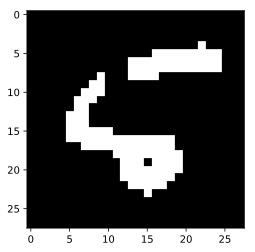

A predit 3 pour:


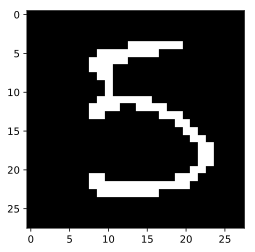

A predit 0 pour:


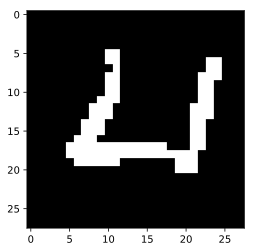

A predit 3 pour:


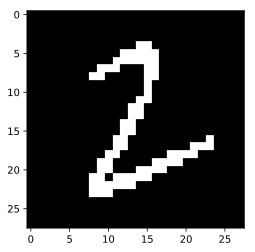

A predit 3 pour:


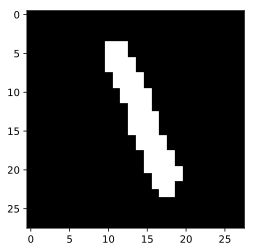

In [17]:
#On affiche un example des images mal predites
showMissed_Bernoulli(5)

In [18]:
#Fonction ultimate_taux_erreur_Bernoulli: calcule le taux d'erreur pour 
#[1,100,500,1000,2000,5000,10000] tests et renvoie le tout dans un tableau

def ultimate_taux_erreur_Bernoulli():
    res=[[1,0],[100,0],[500,0],[1000,0],[2000,0],[5000,0],[10000,0]]
    for i in range(len(res)):
        print("Etape",i,"/6")
        res[i][1] = taux_erreur_Bernoulli(res[i][0])
    print("DONE")
    return res

BN_Bernoulli_resultats  = ultimate_taux_erreur_Bernoulli()


Etape 0 /6
Etape 1 /6
Etape 2 /6
Etape 3 /6
Etape 4 /6
Etape 5 /6
Etape 6 /6
DONE


In [19]:
#On affiche les resultats
print(BN_Bernoulli_resultats)

[[1, 0.0], [100, 0.12], [500, 0.17000000000000004], [1000, 0.18200000000000005], [2000, 0.20299999999999996], [5000, 0.19999999999999996], [10000, 0.15469999999999995]]


In [28]:
#On affiche les resultats du NB Bernoulli proprement en comparaison 
#avec les resultats du NB Gaussien
print("Taux d'erreur par n essais")
for i in range (len(BN_Bernoulli_resultats)):
    print("n=",BN_Bernoulli_resultats[i][0],"| Naive Bayesian: ",round(BN_Gaussien_resultats[i][1],3)," | Binarised: ",round(BN_Bernoulli_resultats[i][1],3))

Taux d'erreur par n essais
n= 1 | Naive Bayesian:  0.0  | Binarised:  0.0
n= 100 | Naive Bayesian:  0.19  | Binarised:  0.12
n= 500 | Naive Bayesian:  0.25  | Binarised:  0.17
n= 1000 | Naive Bayesian:  0.253  | Binarised:  0.182
n= 2000 | Naive Bayesian:  0.274  | Binarised:  0.203
n= 5000 | Naive Bayesian:  0.275  | Binarised:  0.2
n= 10000 | Naive Bayesian:  0.224  | Binarised:  0.155


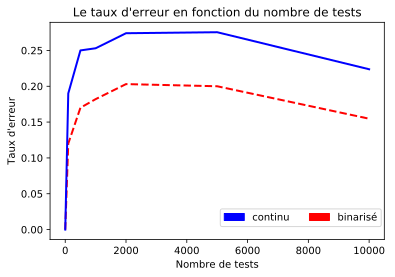

In [29]:
#On affiche les résultats precedents en graphe

import matplotlib.patches as mpatches

pl=plt.plot([row[0] for row in BN_Bernoulli_resultats], [row[1] for row in BN_Bernoulli_resultats], 'r--', linewidth=2.0)
pl=plt.plot([row[0] for row in BN_Gaussien_resultats], [row[1] for row in BN_Gaussien_resultats],'b', linewidth=2.0)

colors = ["b", "r"]
texts = ["continu", "binarisé"]
patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(0.75, 0.1), loc='center', ncol=2 )

plt.ylabel("Taux d'erreur")
plt.xlabel("Nombre de tests")

plt.title("Le taux d'erreur en fonction du nombre de tests")

plt.show()

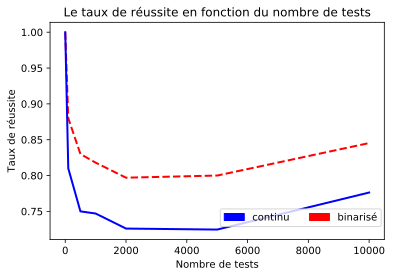

In [30]:

pl=plt.plot([row[0] for row in BN_Bernoulli_resultats], [1-row[1] for row in BN_Bernoulli_resultats], 'r--', linewidth=2.0)
pl=plt.plot([row[0] for row in BN_Gaussien_resultats], [1-row[1] for row in BN_Gaussien_resultats],'b', linewidth=2.0)

colors = ["b", "r"]
texts = ["continu", "binarisé"]
patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(0.75, 0.1), loc='center', ncol=2 )

plt.ylabel("Taux de réussite")
plt.xlabel("Nombre de tests")

plt.title("Le taux de réussite en fonction du nombre de tests")

plt.show()

# Resultat

Nous observons une nette amelioration des performances; le taux d'erreur du Bayésien naïf discret est clairement moins ellevé que le taux d'erreur du Bayésien naïf simple.

# Explorations Supplémentaires


### Taux d'erreur en fonction de la variation d'Alpha dans le lissage de Laplace

Il serait interessant de voir la variance du taux d'erreur en fonction de la variation de l'alpha du lissage de Laplace

ceci sera donc l'objet de l'etude ci-dessous

D'abord on modifie les fonction qu on a ecrite precedement pour avoir un alpha modulable et ainsi avoir des réultats plus facilement 

In [31]:

#Liste des valeurs du lissage en fonction de differents alpha
laplacesS_train_list=[laplaceSmoothing(images_Bernoulli,0.000001),laplaceSmoothing(images_Bernoulli,0.00001),
                      laplaceSmoothing(images_Bernoulli,0.0001),laplaceSmoothing(images_Bernoulli,0.001),
                      laplaceSmoothing(images_Bernoulli,0.01),laplaceSmoothing(images_Bernoulli,0.1),
                      laplaceSmoothing(images_Bernoulli,1),laplaceSmoothing(images_Bernoulli,2),
                      laplaceSmoothing(images_Bernoulli,4),laplaceSmoothing(images_Bernoulli,8),
                      laplaceSmoothing(images_Bernoulli,16),laplaceSmoothing(images_Bernoulli,10000)]

#############################################

def inference_alpha(n,al):
    maximum = -10000
    res = 0
    for classe in range(10):
        somme = 1/10
        for i in range(784):
                py = laplacesS_train_list[al][classe][i]
                data = tests_Bernoulli[n][i]
                somme += data*math.log(py)+(1-data)*math.log(1-py)
        if maximum < somme:
            res = classe
            maximum = somme
    return res

def test_alpha(n,al):
    if inference_alpha(n,al)==lbls_Bernoulli[n]:
        return 1
    return 0

def taux_erreur(n,al):
    tmp = 0
    total= 0
    for i in range(n):
        total+=1       
        tmp+= test_alpha(i,al) #on utilise le testing set
    return 1-tmp/total


In [32]:
#liste des taux d erreur en fonction des differentes valeurs d alpha
alpha_res = [0,0,0,0,0,0,0,0,0,0,0,0]
for al in range(len(laplacesS_train_list)):
    print("For alpha n#",al)
    alpha_res [al] = taux_erreur(500,al)*100
    print("DONE")

For alpha n# 0
DONE
For alpha n# 1
DONE
For alpha n# 2
DONE
For alpha n# 3
DONE
For alpha n# 4
DONE
For alpha n# 5
DONE
For alpha n# 6
DONE
For alpha n# 7
DONE
For alpha n# 8
DONE
For alpha n# 9
DONE
For alpha n# 10
DONE
For alpha n# 11
DONE


In [33]:
print(alpha_res) #Affichage des taux d'erreurs qu on a obtenu 

[16.800000000000004, 17.000000000000004, 17.000000000000004, 17.000000000000004, 17.000000000000004, 17.200000000000003, 17.400000000000006, 17.400000000000006, 17.400000000000006, 17.600000000000005, 18.200000000000006, 67.19999999999999]


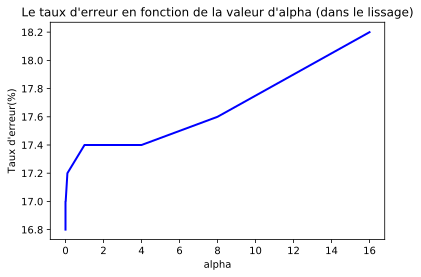

In [34]:
# Affichage sous forme de graphe pour plus de clareté
## on élude la dernière valeur (alpha=10000) car elle biaise trop l'echelle du graphe

xValues=[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,2,4,8,16]
yValues=alpha_res[0:-1]

pl=plt.plot(xValues,yValues,'b', linewidth=2.0)

plt.ylabel("Taux d'erreur(%)")
plt.xlabel("alpha")

plt.title("Le taux d'erreur en fonction de la valeur d'alpha (dans le lissage)")

plt.show()

On observe que plus la valeur de l'alpha du lissage est petite plus le taux d'erreur est bas. Il y a par example une difference claire entre l'alpha=0.000001 avec un taux d'erreur de 16.8% (pour 500 tests) et l'alpha=10000 avec un taux d'erreur de 67.1% (pour 500 tests)

##### Il vaut donc mieux toujours prendre l'alpha le plus petit

### Taux d'erreur en fonction de la variation du nombre d'images de training

In [35]:

nOfImages=[1,5000,10000,15000,20000,25000,30000,35000,40000,45000,50000]

trained_sets =[[],[],[],[],[],[],[],[],[],[],[]]
for n in range(len(nOfImages)):
    trained_sets[n] = laplaceSmoothing(images_Bernoulli[0:nOfImages[n]],0.001)

In [36]:
def inference_varIm(n, nimage):
    maximum = -10000
    res = 0
    for classe in range(10):
        somme = 1/10
        for i in range(784):
                py = trained_sets[nimage][classe][i]
                data = tests_Bernoulli[n][i]
                p3 = data*math.log(py)+(1-data)*math.log(1-py)
                somme += p3
        if maximum < somme:
            res = classe
            maximum = somme
    return res

def test_varIm(n, nimage):
    if inference_varIm(n, nimage)==lbls_Bernoulli[n]:
        return 1
    return 0

def taux_erreur_varIm(n, nimage):
    tmp = 0
    total= 0
    for i in range(n):
        total+=1       
        tmp+= test_varIm(i, nimage) #on utilise le testing set
    return 1-tmp/total

In [37]:
res_t =[0,0,0,0,0,0,0,0,0,0,0]
for i in range(len(nOfImages)):
    print("For image range n#",i)
    res_t[i] =taux_erreur_varIm(500, i)*100
    print("DONE")

For image range n# 0
DONE
For image range n# 1
DONE
For image range n# 2
DONE
For image range n# 3
DONE
For image range n# 4
DONE
For image range n# 5
DONE
For image range n# 6
DONE
For image range n# 7
DONE
For image range n# 8
DONE
For image range n# 9
DONE
For image range n# 10
DONE


In [38]:
print("Les taux d'erreur en fonction du nombre d'images d'entrainement")
print("N#d'images d'entrainement ||   Taux d'erreur")
for i in range(len(nOfImages)):
    print(nOfImages[i],"                    ||      ",round(res_t[i],3),"%")

Les taux d'erreur en fonction du nombre d'images d'entrainement
N#d'images d'entrainement ||   Taux d'erreur
1                     ||       90.0 %
5000                     ||       24.4 %
10000                     ||       25.4 %
15000                     ||       24.2 %
20000                     ||       22.0 %
25000                     ||       20.8 %
30000                     ||       18.6 %
35000                     ||       17.6 %
40000                     ||       16.8 %
45000                     ||       16.8 %
50000                     ||       17.0 %


In [1]:
# Affichage sous forme de graphe pour plus de clareté

xValues= nOfImages
yValues=res_t

pl=plt.plot(xValues,yValues,'b', linewidth=2.0)

plt.ylabel("Taux d'erreur(%)")
plt.xlabel("Nombre d'images de training")

plt.title("Le taux d'erreur en fonction du nombre d'images d'entrainement")

plt.show()

NameError: name 'nOfImages' is not defined

On constate que le taux d'erreur baisse tres vite entre 0 et 5000 images d'entrainement.

Au dela de 5000 images d'entrainement la precision est deja plutot bonne mais on peut encore affiner les résultat on ajoutant des images d entrainement (jusqu'a 40000).

Au dela de 40000 images il ne semble pas necessaire d'ajouter plus d'images d'entrainement.